## 123Iによるdosimetryにおいてコリメータの違いが定量性に与える影響

LEHRとMEコリメータで比較
空間分解能 LEHR > ME
penetration LEHR < ME

jaszakファントムを使用して比較


####  symbiaT16シミレーション環境の構築
##### シンチレーションカメラ  
___  
index19  
Photon direction = 3

___  
energy resulution index22    
- energy resolution  index22 = 0 あるいは switch /FE:filename 
- index98 = 1 として　FWHM = a + b√(Ene + cEne^2)  を設定する
- 設定方法は simind.iniの46,47,48でa,b,cを設定可能
- symbiaのエネルギー分解能はFWHM = -0.534 + 0.946√(E+0.006E^2)　として.erfファイルで設定する
___  
index24  
Number of photon Histrories * 1E6(試行回数)  =   100  
___  
index27  
keV/channel = 2.00  
___  
index28  
pixel size in simulated image  
ズーム変更時にもここでピクセルサイズを変更する  
___
##### コリメータパラメータ　　
___  
index53  
collimator routine = 1  
penetrationなどをシミュレーションするときには使用する  




In [4]:
import numpy as np
import pytomography
from pytomography.io.SPECT import simind
from pytomography.transforms.SPECT.attenuation import SPECTAttenuationTransform
from pytomography.transforms.SPECT.psf import SPECTPSFTransform
# from pytomography.transforms import SPECTAttenuationTransform, SPECTPSFTransform
from pytomography.projectors.SPECT import SPECTSystemMatrix
from pytomography.algorithms import OSEM, FilteredBackProjection
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LinearSegmentedColormap
import torch
import re

colors = np.loadtxt('pet_colors.txt').reshape(-1,3)/255.0
custom_cmap = LinearSegmentedColormap.from_list('custom_colormap', colors)

PenetrationRoutineのヘッダーファイルの情報を編集する

In [5]:

def change_header_name_of_data_file(file_path, new_file_name):
    with open(file_path, 'r') as file:
        file_data = file.read()
    
    file_data = re.sub(r'(?<=!name of data file := ).+', new_file_name, file_data)

    with open(file_path, 'w') as file:
        file.write(file_data)


In [3]:
def save_binary_file(data, file_path):

# Save the source_prediction as binary data
    with open(file_path, 'wb') as f:
        output = np.transpose(data, (2, 1, 0))  # Transpose to depth, height, width order
        f.write(output.tobytes())
# End Generation Here

In [4]:
def read_binary_file(file_path, width, height, depth):
    with open(file_path, 'rb') as f:
        data = np.frombuffer(f.read(), dtype=np.float32)
        data = data.reshape((width, height, depth))

    return np.transpose(data, (2, 1, 0))


In [5]:
def create_roi_map(sphere_file_path, output_file_path, width, height, depth, voxel_size):
    # Initialize a 3D array with zeros
    array_3d = np.zeros((width, height, depth), dtype=np.float32)

    # Load the data from the synbia.inp file in the current directory
    with open(sphere_file_path, 'r') as f:
        spheres_data = [list(map(float, line.strip().split(","))) for line in f if line.strip()]
    
    # Convert the sphere data from cm to voxel units
    spheres_data = np.array(spheres_data) * 10  # 1 cm = 10 mm

    volume_center_x = width * voxel_size / 2
    volume_center_y = height * voxel_size / 2
    volume_center_z = depth * voxel_size / 2
    # Iterate over the spheres data
    flg = 1
    for sphere in spheres_data:
        # flg += 1
        radius_z, radius_x, radius_y, center_z, center_x, center_y, _, _ = sphere
        
        target_center_x = volume_center_x + center_x
        target_center_y = volume_center_y - center_y
        target_center_z = volume_center_z + center_z
        # Iterate over the 3D array
        for k in range(depth):
            for j in range(height):
                for i in range(width):
                    # Calculate the distance from the center of the sphere
                    dist_x = (i * voxel_size + voxel_size / 2 - target_center_x) ** 2 / radius_x ** 2
                    dist_y = (j * voxel_size + voxel_size / 2 - target_center_y) ** 2 / radius_y ** 2
                    dist_z = (k * voxel_size + voxel_size / 2 - target_center_z) ** 2 / radius_z ** 2
                    # If the voxel is inside the sphere, set its value to 1
                    if dist_x + dist_y + dist_z <= 1:
                        array_3d[i, j, k] = flg

    # Write the 3D array to a binary file
    with open(output_file_path, 'wb') as f:
        f.write(array_3d.astype(np.float32).tobytes())

    return array_3d

# roi_map = create_roi_map("symbia.inp", 'inp.bin', 128, 128, 128, 4.4)
# import matplotlib.pyplot as plt
# plt.pcolormesh(roi_map[:,:,64].T, cmap='Greys_r', vmax=7)
# plt.colorbar(label='Counts')



In [9]:
target_file_path = r"lehr_main.b02"
png_file_name = "collimated_prim.png"
header_file_path = r"lehr_main/lehr_main.h00"
change_header_name_of_data_file(header_file_path, target_file_path)

print(target_file_path)
print(header_file_path)

attenuation_map = simind.get_attenuation_map(r"lehr_main/lehr_main.hct")
projections = simind.get_projections(header_file_path)


projections.shape
attenuation_map.shape
att_transform = SPECTAttenuationTransform(attenuation_map)
print(att_transform)
psf_meta = simind.get_psfmeta_from_header(header_file_path)
psf_transform = SPECTPSFTransform(psf_meta)

object_meta, proj_meta = simind.get_metadata(header_file_path)

system_matrix = SPECTSystemMatrix(
    obj2obj_transforms=[att_transform,],
    proj2proj_transforms=[],
    object_meta = object_meta,
    proj_meta = proj_meta
)

activity = 500
dT = 20

torch.poisson(projections*activity*dT)

osem = OSEM(
    projections = projections,
    system_matrix = system_matrix,
)

source_prediction = osem(n_iters=10, n_subsets=8)

source_prediction.shape
source_prediction = source_prediction[0].cpu().numpy()
# save_binary_file(source_prediction, "test04.dat")
roi_map = create_roi_map("symbia.inp", 'inp.bin', 256, 256, 256, 2.2)
# save_binary_file(roi_map, "roi.dat")
# # plt.pcolormesh(attenuation_map[0,:,:,64].cpu().T, cmap='Greys_r')
plt.pcolormesh(roi_map[:,:,128].T, cmap='Greys_r')
plt.pcolormesh(source_prediction[:,:,128].T, cmap=custom_cmap, alpha=0.5)
plt.colorbar(label='Counts')
plt.axis('off')
plt.show()

# for i in range(44,84):
#     for j in range(44,84):
#         if source_prediction[i,j,64] > 0.002:
#             print(str(source_prediction[i,j,64]) + "_" + str(roi_map[i,j,64]))

# plt.pcolormesh(projections[0,0].cpu().T, cmap='nipy_spectral')
# plt.colorbar()
# plt.savefig(png_file_name)

lehr_main/lehr_main.b02
lehr_main/lehr_main.h00


FileNotFoundError: [Errno 2] No such file or directory: 'lehr_main\\lehr_main/lehr_main.b02'

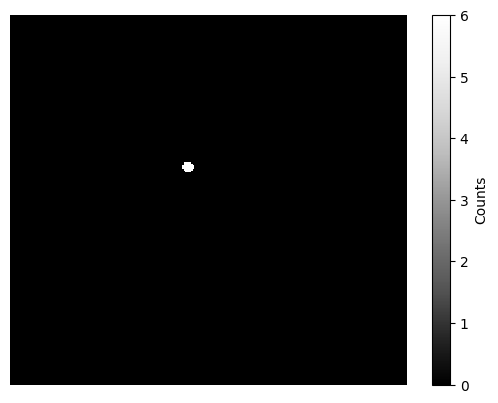

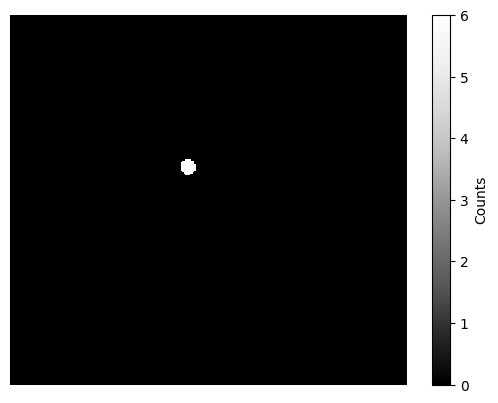

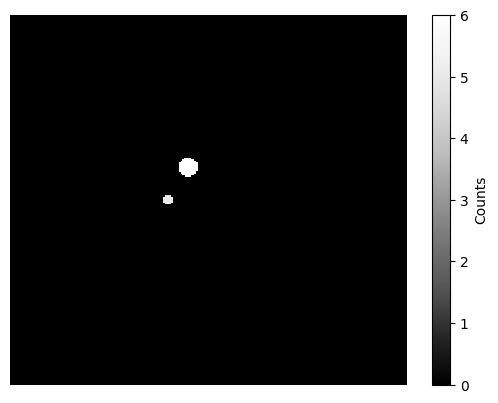

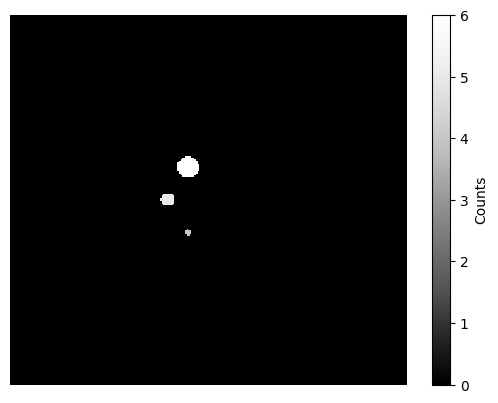

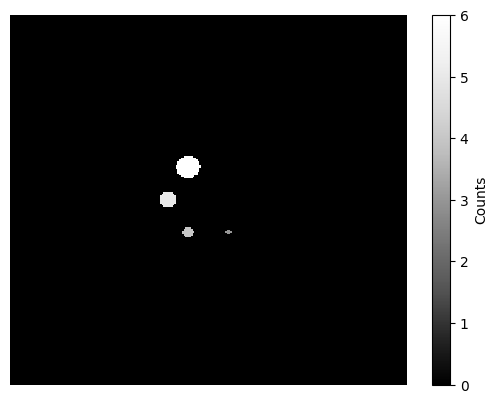

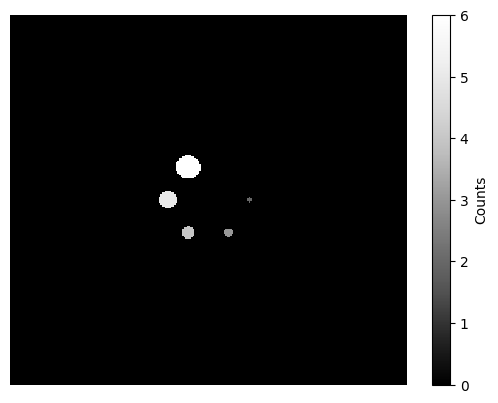

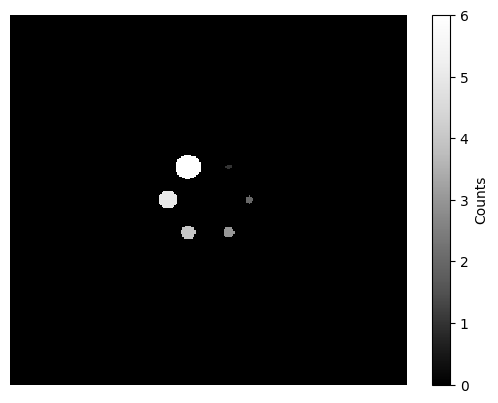

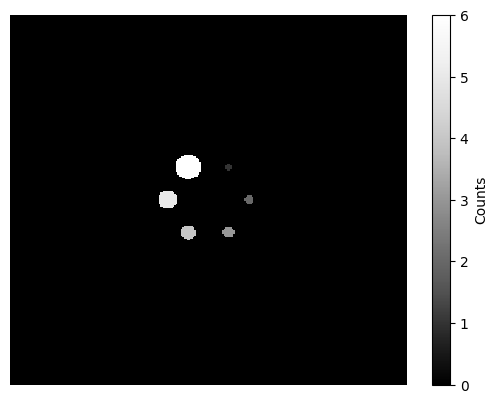

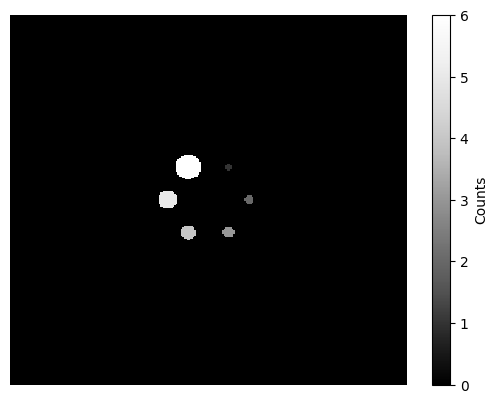

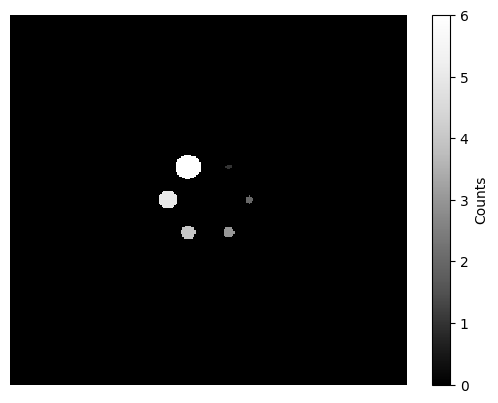

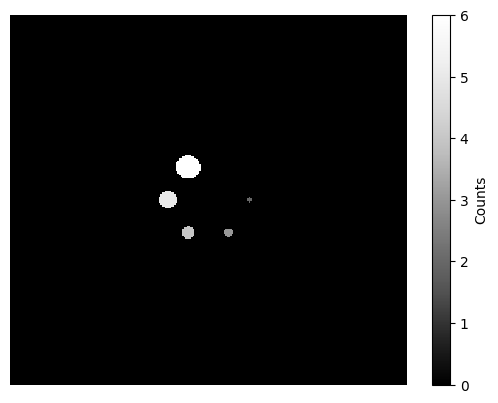

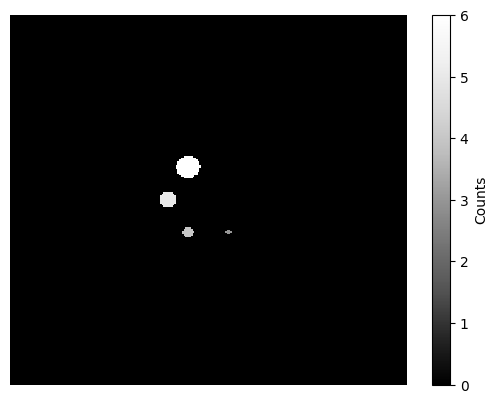

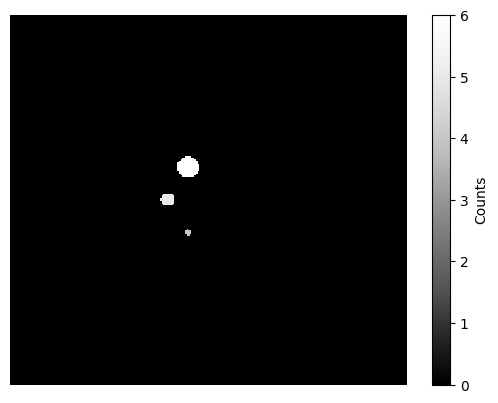

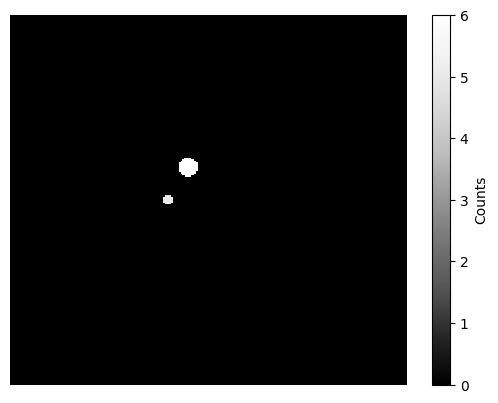

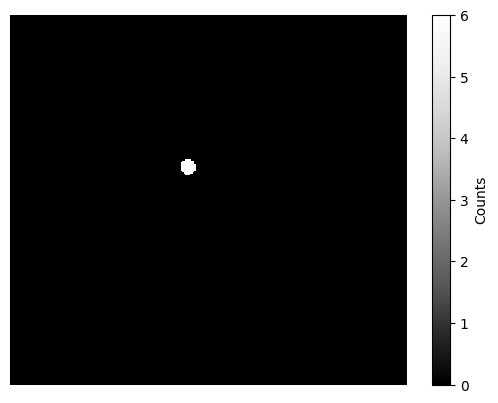

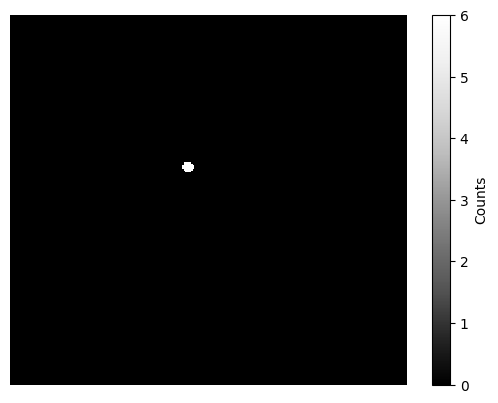

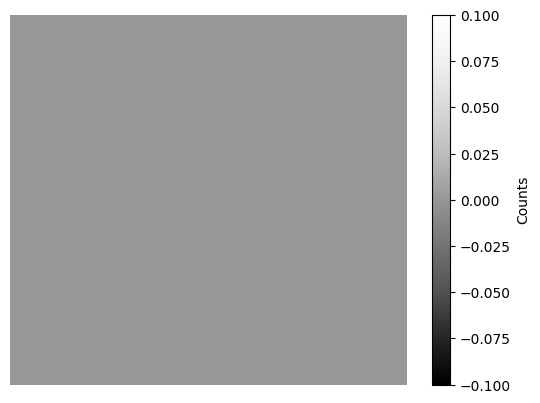

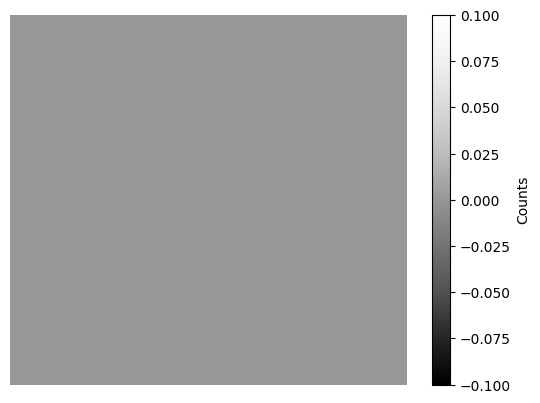

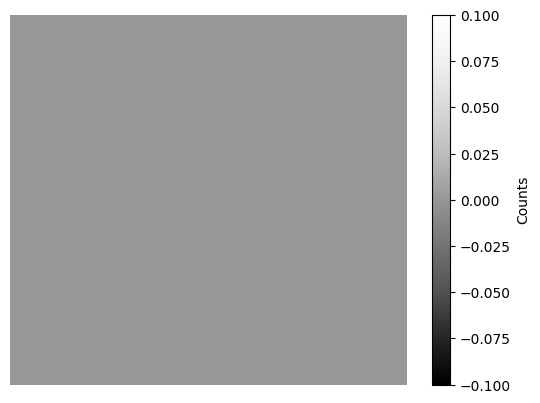

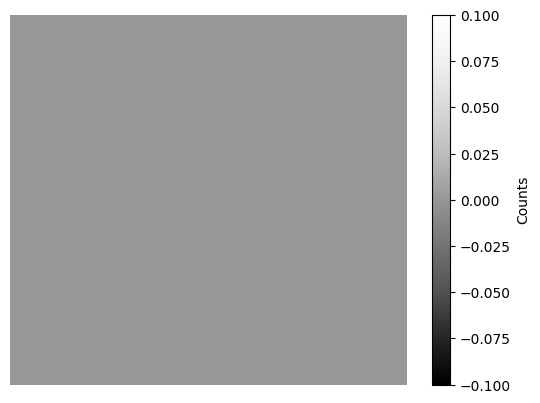

<Figure size 640x480 with 0 Axes>

In [17]:

for i in range(120, 140):
    plt.pcolormesh(roi_map[:,:,i].T, cmap='Greys_r')
    # plt.pcolormesh(source_prediction[:,:,i].T, cmap=custom_cmap, alpha=0.2)
    plt.colorbar(label='Counts')
    plt.axis('off')
    plt.show()
    plt.clf()

In [21]:
# グラフを書き出す
import numpy as np

files = [("b1.prn","all_interaction"),
         ("b2.prn","collimated_prim"),
         ("b3.prn","penetration_prim"),
         ("b4.prn","scatter_prim"),
         ("b5.prn","xrays_collim_prim")]   #,
        #  ("b6.prn","collimated_scatter"),
        #  ("b7.prn","penetration_collim_scatter"),
        #  ("b8.prn","scatter_collim_scatter"),
        #  ("b9.prn","xrays_collim_scatter")]
for file_name, plot_label in files:
    data = np.loadtxt(file_name)
    x, y = data[:,0]*2, data[:,1]
    plt.xlim(0, 600)
    # plt.ylim(0,150)
    plt.title(plot_label)
    plt.plot(x, y, label=plot_label)
    plt.legend()
    plt.savefig("symbia_dir/graph/point10000/graphplot_" + plot_label + ".png")
    plt.clf()

# for file in files:
#     data = np.loadtxt(file)
#     x, y = data[:,0], data[:,1]
#     plt.plot(x, y, lavel=file)
#     plt.legend()
#     plt.savefig(file + ".png")


<Figure size 640x480 with 0 Axes>

#### Count/MBqを求める  
- all interaction -> b1  
- only collimated primary -> b2  
(without penetration + scatter)  
- without penetration -> b1 - b3  
- without scatter -> b1 - b4  




In [32]:
b1 = "lehr_p10000.b01"
b2 = "lehr_p10000.b02"
b3 = "lehr_p10000.b03"
b4 = "lehr_p10000.b04"
files = ["lehr_p10000.b01",
         "lehr_p10000.b02",
         "lehr_p10000.b03",
         "lehr_p10000.b04"
         ]
header_file_path = "lehr_p10000.h00"
prjs = []

for file in files:
    change_header_name_of_data_file(header_file_path, file)
    prj = simind.get_projections(header_file_path)
    prjs.append(prj)

print("all interaction : " + str(prjs[0].sum()))
print("collimated praimary : " + str(prjs[1].sum()))
print("without penetration : " + str(prjs[0].sum() - prjs[2].sum()))

all interaction : tensor(160.2599, device='cuda:0')
collimated praimary : tensor(66.0253, device='cuda:0')
without penetration : tensor(137.1427, device='cuda:0')
